In [1]:
[1]
# Install required packages
!pip install rdkit pandas matplotlib seaborn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 17.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01


In [2]:
[2]
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem

In [12]:
[3]
# Load BACE1 inhibitor data
bace1_df = pd.read_csv("../drug_design_2/ro5_properties_bace1_filtered.csv")
print(f"Total number of compounds: {bace1_df.shape[0]}")

# Print column names
print("Available columns:")
print(bace1_df.columns.tolist())

# SMILES column is already identified
smiles_column = 'smiles'
print(f"Using '{smiles_column}' as the SMILES column.")

# Molecule column is already present
mol_column = 'ROMol'
print(f"Using '{mol_column}' as the molecule column.")

bace1_df.head()

Total number of compounds: 6078
Available columns:
['molecule_chembl_id', 'IC50', 'units', 'smiles', 'pIC50', 'molecular_weight', 'n_hba', 'n_hbd', 'logp', 'ro5_fulfilled']
Using 'smiles' as the SMILES column.
Using 'ROMol' as the molecule column.


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL3969403,0.0002,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,12.698970,429.127089,7,2,2.12408,True
1,CHEMBL3937515,0.0009,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,12.045757,435.137653,8,2,1.65600,True
2,CHEMBL3949213,0.0010,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,12.000000,455.142739,7,2,2.65828,True
3,CHEMBL3955051,0.0018,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,11.744727,455.123895,7,2,2.58500,True
4,CHEMBL3936264,0.0057,nM,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,11.244125,442.092261,7,2,2.07520,True


In [15]:
[4]
# Updated: Remove random sampling and use all active compounds
active_mols = []
for _, row in active_df.iterrows():
    mol = Chem.MolFromSmiles(row[smiles_column])
    if mol is not None:
        mol.SetProp("_Name", row['molecule_chembl_id'])
        active_mols.append(mol)

print(f"Number of valid molecules: {len(active_mols)}")

Number of valid molecules: 2669


In [16]:
[5]
# Define a helper function to visualize molecules with highlighted MCS
def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = molecules.copy()
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label:
        legends = [x.GetProp("_Name") for x in molecules]

    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Chem.rdGeometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

MCS1 contains 8 atoms and 7 bonds.
MCS SMARTS string: [#7]-,:[#6]-,:[#6]:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-[#6]


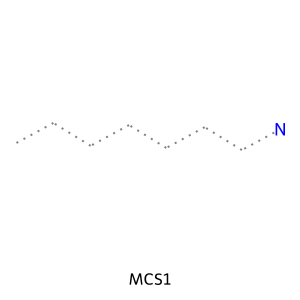

In [17]:
[6]
# Perform MCS analysis with default parameters
mcs1 = rdFMCS.FindMCS(sample_mols)
print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
print("MCS SMARTS string:", mcs1.smartsString)

# Draw substructure from SMARTS
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

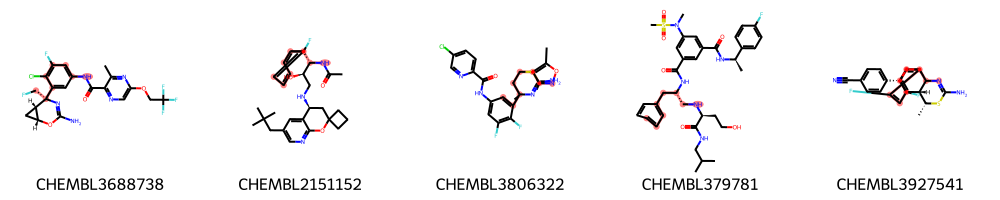

In [18]:
[7]
# Visualize molecules with highlighted MCS
highlight_molecules(sample_mols, mcs1, 5)

MCS2 contains 11 atoms and 10 bonds.
MCS SMARTS string: [#6](-,:[#6]-,:[#6]-,:[#6](-,:[#6])-,:[#6]-,:[#6]:,-[#6]-,:[#6]-,:[#7])-,:[#6]


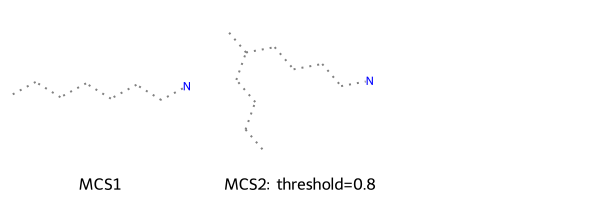

In [19]:
[8]
# MCS with threshold
threshold = 0.8
mcs2 = rdFMCS.FindMCS(sample_mols, threshold=threshold)
print(f"MCS2 contains {mcs2.numAtoms} atoms and {mcs2.numBonds} bonds.")
print("MCS SMARTS string:", mcs2.smartsString)

# Draw substructure
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1, m2], legends=["MCS1", f"MCS2: threshold={threshold}"])

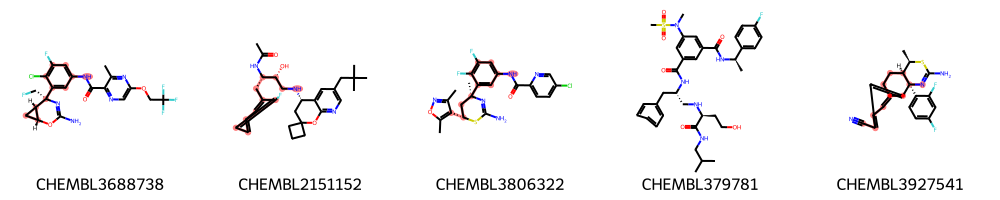

In [20]:
[9]
# Visualize molecules with highlighted MCS2
highlight_molecules(sample_mols, mcs2, 5)

MCS3 contains 6 atoms and 6 bonds.
MCS SMARTS string: [#6]1:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@1


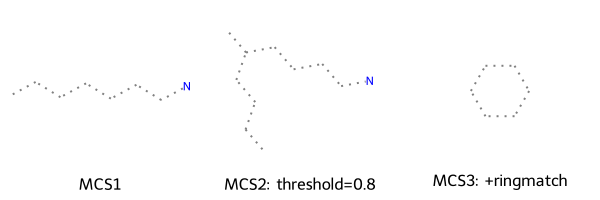

In [21]:
[10]
# MCS with ring matches ring only
mcs3 = rdFMCS.FindMCS(sample_mols, threshold=threshold, ringMatchesRingOnly=True)
print(f"MCS3 contains {mcs3.numAtoms} atoms and {mcs3.numBonds} bonds.")
print("MCS SMARTS string:", mcs3.smartsString)

# Draw substructure
m3 = Chem.MolFromSmarts(mcs3.smartsString)
Draw.MolsToGridImage([m1, m2, m3], legends=["MCS1", f"MCS2: threshold={threshold}", "MCS3: +ringmatch"])

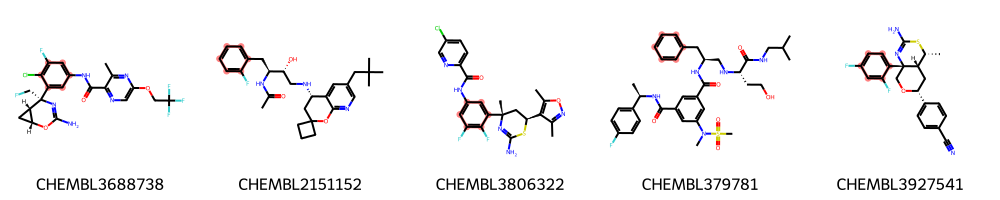

In [22]:
[11]
# Visualize molecules with highlighted MCS3
highlight_molecules(sample_mols, mcs3, 5)

In [23]:
[12]
# Interactive widget to explore different thresholds
from ipywidgets import interact, fixed
import ipywidgets as widgets

def render_mcs(molecules, percentage):
    """Interactive widget helper."""
    tmcs = rdFMCS.FindMCS(molecules, threshold=percentage / 100.0)
    if tmcs is None:
        print("No MCS found")
        return None

    m = Chem.MolFromSmarts(tmcs.smartsString)
    print(f"MCS SMARTS: {tmcs.smartsString}")
    print(f"Number of atoms: {tmcs.numAtoms}, Number of bonds: {tmcs.numBonds}")
    return Draw.MolToImage(m)

interact(
    render_mcs,
    molecules=fixed(sample_mols),
    percentage=widgets.IntSlider(min=0, max=100, step=10, value=80),
);

interactive(children=(IntSlider(value=80, description='percentage', step=10), Output()), _dom_classes=('widget…

# BACE1 Inhibitor Analysis: Maximum Common Substructure (MCS) Approach

## 1. Data Loading and Preprocessing

We start by loading the BACE1 inhibitor dataset and examining its structure:

Understanding the dataset's structure is crucial for subsequent analysis. It allows us to identify key columns like SMILES strings and activity data (pIC50). BACE1 inhibitors are potential therapeutic agents for Alzheimer's disease, making this dataset valuable for drug discovery efforts.

## 2. Filtering for Highly Active Compounds

We filter the dataset to focus on highly active compounds (pIC50 > 9).

By focusing on highly active compounds, we concentrate our analysis on the most potent BACE1 inhibitors. This helps identify structural features that may be crucial for high activity against BACE1, a key enzyme in the formation of amyloid-β plaques.

## 3. Creating RDKit Molecule Objects

We convert SMILES strings to RDKit molecule objects.

RDKit molecule objects allow for advanced cheminformatics operations, including substructure searching and MCS analysis. This step is essential for performing detailed structural analysis of the compounds.

## 4. Maximum Common Substructure (MCS) Analysis

We perform MCS analysis with different parameters:
- Default parameters
- Threshold of 80%
- Ring matches ring only

MCS analysis helps identify common structural features among active compounds. Different parameters allow for varying degrees of strictness in matching:
- Default parameters: Finds the largest common substructure across all molecules.
- Threshold: Allows for some flexibility, finding a substructure common to at least 80% of the molecules.
- Ring matches ring only: Ensures that ring systems are matched appropriately, which is important for many drug-like molecules.

This analysis can reveal key structural motifs that contribute to BACE1 inhibition.

## 5. Visualization of Results

We visualize the MCS results and highlight them in sample molecules.

Visualization aids in interpreting the MCS results, allowing for quick identification of common structural motifs among active compounds. This can guide structure-activity relationship (SAR) studies and inform the design of new, potentially more effective BACE1 inhibitors.

## 6. Interactive Exploration

We provide an interactive widget to explore different MCS thresholds.

This allows for dynamic exploration of how changing the threshold affects the identified common substructure, providing insights into the structural variability among active compounds. It can help in understanding the balance between conserved features and structural diversity in effective BACE1 inhibitors.